## Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io 
import random
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Dataset Processing 

### Read in the original dataset 

In [2]:
train_dl_origin = torch.load('Dataset/train_dl.pt')
valid_dl_origin = torch.load('Dataset/valid_dl.pt')

train_CSI = train_dl_origin.dataset[:][0]
train_label = train_dl_origin.dataset[:][1][:,0:2]

valid_CSI = valid_dl_origin.dataset[:][0]
valid_label = valid_dl_origin.dataset[:][1][:,0:2]

In [3]:
print(train_label)

tensor([[-37.2707, -21.4267],
        [-38.7407, -16.3757],
        [-25.9407, -16.6947],
        ...,
        [-32.1957, -22.0517],
        [-16.1297, -14.0287],
        [-37.0697, -16.6887]])


### CSI Processing: Take Modulus of complex matrices

In [4]:
train_CSI_modulus = torch.abs(train_CSI)
valid_CSI_modulus = torch.abs(valid_CSI)

In [5]:
print(train_CSI_modulus.shape)
print(valid_CSI_modulus.shape)
print(train_label.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])
torch.Size([15000, 2])


###  CSI Processing: Normalize to [0,1]

In [6]:
# Min-Max Scaling
min_value = torch.min(train_CSI_modulus)
max_value = torch.max(train_CSI_modulus)

normalized_train_CSI_modulus = (train_CSI_modulus - min_value) / (max_value - min_value)
normalized_valid_CSI_modulus = (valid_CSI_modulus - min_value) / (max_value - min_value)

In [7]:
# Convert 4d to 2d
train_data_2d = normalized_train_CSI_modulus.view(normalized_train_CSI_modulus.size(0), -1)  # Reshape to (15000, 4 * 1632)
valid_data_2d = normalized_valid_CSI_modulus.view(normalized_valid_CSI_modulus.size(0), -1)  # Reshape to (15000, 4 * 1632)

In [25]:
train_data_2d.shape
valid_data_2d.shape

torch.Size([5000, 6528])

#   ML w/ Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
# Create the model
model = LinearRegression()
# Fit the model
model.fit(train_data_2d, train_label)
# Score the model
print(model.score(train_data_2d, train_label))
print(model.score(valid_data_2d, valid_label))


0.9018167298339954
0.6891206395129608


In [9]:
from sklearn.metrics import mean_squared_error
train_predictions = model.predict(train_data_2d)
valid_predictions = model.predict(valid_data_2d)
train_mse = mean_squared_error(train_label, train_predictions)
valid_mse = mean_squared_error(valid_label, valid_predictions)

### Lets use L1 regularization now
- We expect this to perform poorly since all features are equally important

In [11]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=.1, normalize=False)
lasso_model.fit(train_data_2d, train_label)

C:\Users\Joey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Lasso(alpha=0.1, normalize=False)

In [12]:
train_score = lasso_model.score(train_data_2d, train_label)
valid_score = lasso_model.score(valid_data_2d, valid_label)

print("Training R-squared:", train_score)
print("Validation R-squared:", valid_score)

Training R-squared: 0.28614985912199603
Validation R-squared: 0.28412069940421636


In [13]:
train_predictions_l = lasso_model.predict(train_data_2d)
valid_predictions_l = lasso_model.predict(valid_data_2d)
train_mse_l = mean_squared_error(train_label, train_predictions_l)
valid_mse_l = mean_squared_error(valid_label, valid_predictions_l)

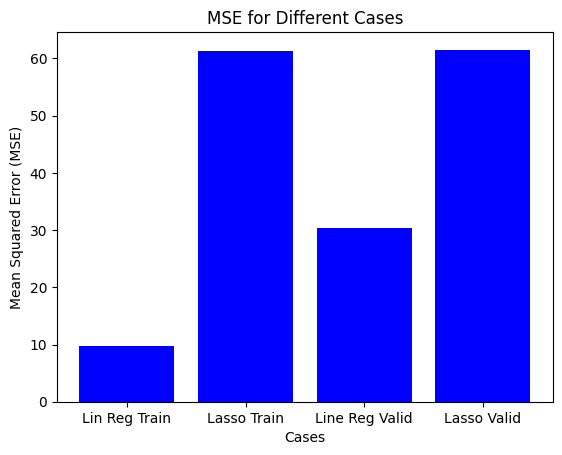

In [14]:
mse_values = [train_mse, train_mse_l, valid_mse, valid_mse_l]  
case_labels = ['Lin Reg Train', 'Lasso Train', 'Line Reg Valid', 'Lasso Valid']  

plt.bar(case_labels, mse_values, color='blue')
plt.xlabel('Cases')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Cases')

plt.show()

# MLP Approach

In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(4*1632, 500)  # input layer (4*1632 nodes) -> hidden layer (100 nodes)
        self.layer2 = nn.Linear(500, 500)  # hidden layer (100 nodes) -> hidden layer (100 nodes)
        self.layer3 = nn.Linear(500, 100)  # hidden layer (100 nodes) -> hidden layer (100 nodes)
        self.layer4 = nn.Linear(100, 2)  # hidden layer (100 nodes) -> output layer (2 nodes)

    def forward(self, x):
        return self.layer4(F.relu(self.layer3(F.relu(self.layer2(F.relu(self.layer1(x)))))))

net = Net()

In [36]:
import torch.optim as optim

criterion = nn.MSELoss()  # Example loss function for regression
optimizer = optim.SGD(net.parameters(), lr=0.01)  # Example optimizer

In [37]:
train_data_2d = torch.tensor(train_data_2d, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32)

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = net(train_data_2d)
    loss = criterion(output, train_label)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

C:\Users\Joey\AppData\Local\Temp\ipykernel_26672\1414316764.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_2d = torch.tensor(train_data_2d, dtype=torch.float32)


Epoch [1/100], Loss: 382.4122314453125
Epoch [2/100], Loss: 375.0832214355469
Epoch [3/100], Loss: 367.7294006347656
Epoch [4/100], Loss: 358.0617980957031
Epoch [5/100], Loss: 339.6568908691406
Epoch [6/100], Loss: 274.2060241699219
Epoch [7/100], Loss: 1067.10400390625
Epoch [8/100], Loss: 361.3076477050781
Epoch [9/100], Loss: 356.3495788574219
Epoch [10/100], Loss: 346.3618469238281
Epoch [11/100], Loss: 338.71881103515625
Epoch [12/100], Loss: 324.2817687988281
Epoch [13/100], Loss: 277.99468994140625
Epoch [14/100], Loss: 390.79248046875
Epoch [15/100], Loss: 331.1980285644531
Epoch [16/100], Loss: 326.63702392578125
Epoch [17/100], Loss: 322.1578674316406
Epoch [18/100], Loss: 317.74365234375
Epoch [19/100], Loss: 313.3751525878906
Epoch [20/100], Loss: 309.0205383300781
Epoch [21/100], Loss: 304.627197265625
Epoch [22/100], Loss: 300.1068115234375
Epoch [23/100], Loss: 295.31036376953125
Epoch [24/100], Loss: 289.9850769042969
Epoch [25/100], Loss: 283.69305419921875
Epoch [26/

### A low r^2 value is indicative of poor performance

In [39]:
#Evaluate the accuracy of the model
from sklearn.metrics import r2_score
net.eval()
with torch.no_grad():
    train_predictions = net(train_data_2d)
    test_predictions = net(valid_data_2d)
print("Training R-squared:", r2_score(train_label, train_predictions))
print("Validation R-squared:", r2_score(valid_label, test_predictions))


Training R-squared: 1.57096027612047e-05
Validation R-squared: -0.0001931691991089446
